# **<center><font style="color:rgb(134,19,348)">HUMAN ACTION RECOGNITION</font></center>**
**<center>Course of Foundations of Deep Learning</center>**
**<center>University of Milano - Bicocca</center>**
**<center>Academic Year 2023/2024</center>**

## **<font style="color:rgb(134,19,348)">0- INTRO</font>**

This project is developed by **Sara Nava** (mat. **870885**) and **Giulia Saresini** (mat. **864967**). It aims to develop a neural network capable of classifying seven human actions from the HMDB51 video dataset.

### **<font style="color:rgb(134,19,348)">Project Overview</font>**

The goal of this project is to build a robust neural network model for human action recognition. The model will be trained to classify videos into one of seven predefined human actions **('kick', 'sword', 'kiss', 'hug', 'shake_hands', 'fencing', 'punch')** based on the HMDB51 dataset. This dataset contains videos showcasing various human actions.

### **<font style="color:rgb(134,19,348)">Dataset</font>**

The HMDB51 dataset includes a diverse range of human actions such as **walking, running, jumping**, and more. Each action category consists of multiple video clips showcasing different instances of the action being performed (**https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/**).

### **<font style="color:rgb(134,19,348)">Approach</font>**

Our approach involves:

- **Data Preparation:** Preprocessing the video data to extract relevant frames and normalize them for training models.
  
- **Model Development:** Designing and training **3D CNN** and **LRCN** architectures suitable for video classification tasks. 
  
- **Evaluation:** Assessing the performance of the trained models using metrics such as accuracy and loss. 
### **<font style="color:rgb(134,19,348)">Objective</font>**

This project represents an initial attempt, acknowledging that the results obtained may not represent the optimal performance achievable. Due to **computational constraints** on our machines, we were limited in experimenting with a smaller number of parameters and simpler models, as more complex models caused kernel crashes. This is why we focused on classifying only 7 out of the 51 action classes available in the HMDB51 dataset. **Our goal was** not to surpass existing benchmarks but **to present a logically structured approach that reflects thoughtful decisions made under these constraints**.


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

In [73]:
# Import the required libraries.
import cv2
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

In [74]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [72]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">1- DATA LOADING AND VISUALIZATION</font>**

**Note**: The data was downloaded manually from the following link (http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar). The files were in .rar format, so decompression was necessary. Inside the decompressed folder, the videos were organized into subfolders corresponding to their classes, which were also compressed in .rar files, requiring further decompression.


First, we created a copy of the directory containing the videos and removed all videos from that copy that did not belong to the seven classes of interest.

In [126]:
import os
import cv2
import shutil

def copy_directory(src, dest):
    if os.path.exists(dest):
        shutil.rmtree(dest)
    shutil.copytree(src, dest)

# Path to the root folder containing the class subfolders
root_folder = 'hmdb51_org_unrared'
# Path to the copy of the root folder
copy_folder = 'hmdb51_org_human_inter'

# Copy the directory
if os.path.isdir(copy_folder):
    print('The directory already exists.')
else:
    print("The directory doesn't exist. Creating...")
    copy_directory(root_folder, copy_folder)
    print(f"Copied {root_folder} to {copy_folder}")

The directory already exists.


In [59]:
# Main directory path
main_folder = 'hmdb51_org_human_inter'

# List of subdirectories to keep
folders_to_keep = ['fencing', 'hug', 'kick', 'kiss', 'punch', 'shake_hands', 'sword']

# Get folders' name belonging to main_folder
all_folders = [name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))]

# Discard folders 
for folder in all_folders:
    folder_path = os.path.join(main_folder, folder)
    if folder not in folders_to_keep:
        # Elimina le sottocartelle che non sono nella lista folders_to_keep
        shutil.rmtree(folder_path)
        print(f"Discarding the folder: {folder_path}")
    else:
        print(f"Keeping the folder: {folder_path}")

print("End cleaning.")

Discarding the folder: hmdb51_org_human_inter/ride_bike
Keeping the folder: hmdb51_org_human_inter/kick
Discarding the folder: hmdb51_org_human_inter/smoke
Keeping the folder: hmdb51_org_human_inter/sword
Discarding the folder: hmdb51_org_human_inter/golf
Discarding the folder: hmdb51_org_human_inter/climb
Discarding the folder: hmdb51_org_human_inter/walk
Discarding the folder: hmdb51_org_human_inter/sword_exercise
Discarding the folder: hmdb51_org_human_inter/hit
Discarding the folder: hmdb51_org_human_inter/swing_baseball
Discarding the folder: hmdb51_org_human_inter/brush_hair
Discarding the folder: hmdb51_org_human_inter/ride_horse
Discarding the folder: hmdb51_org_human_inter/dive
Discarding the folder: hmdb51_org_human_inter/shoot_bow
Discarding the folder: hmdb51_org_human_inter/sit
Keeping the folder: hmdb51_org_human_inter/kiss
Discarding the folder: hmdb51_org_human_inter/jump
Keeping the folder: hmdb51_org_human_inter/hug
Discarding the folder: hmdb51_org_human_inter/pushup

In [ ]:
# Run this code to remove eventual conflicting files
def remove_ds_store_files(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

# Remove .DS_Store files
remove_ds_store_files('hmdb51_org_human_inter')

## **<font style="color:rgb(134,19,348)">2- DATASET PRE-PROCESSING</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

In [4]:
import os

# Check if the directory has been correctly cleaned: the list Action must be equal to folders_to_keep
Actions = []

# Scan the directory
for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)
    if os.path.isdir(folder_path):
        Actions.append(folder_name)

# Print "Actions" vector
print("Vettore Actions:", Actions)

Vettore Actions: ['kick', 'sword', 'kiss', 'hug', 'shake_hands', 'fencing', 'punch']


In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 60

# Specify the directory containing the dataset.
DATASET_DIR = "hmdb51_org_human_inter"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = Actions

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

## **<font style="color:rgb(134,19,348)">3- DATA VISUALIZATION</font>**

Below are some example frames extracted from a random video for each of the considered classes.

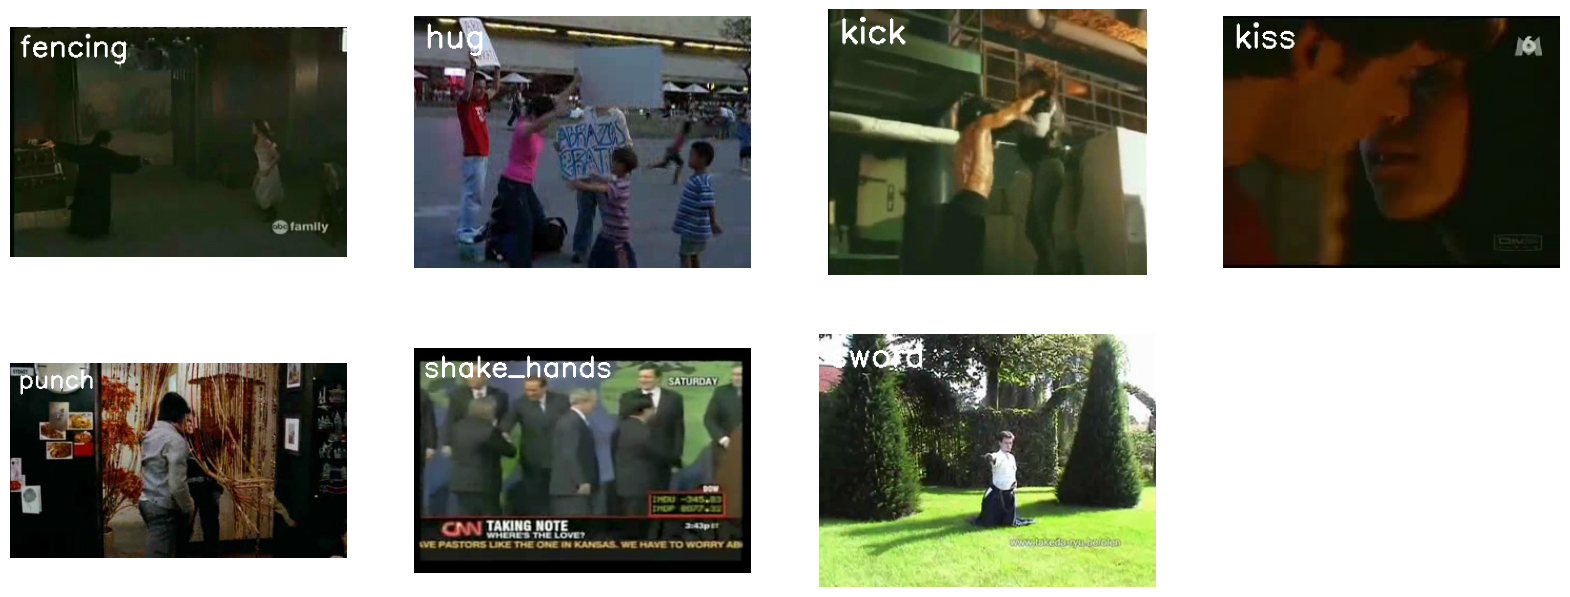

In [63]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories.
all_classes_names = Actions


# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = [0,1,2,3,4,5,6]
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'hmdb51_org_human_inter/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'hmdb51_org_human_inter/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

Below, we plotted a histogram of frame counts in videos from the selected classes of interest to determine an appropriate number of frames to extract, and also the video distribution in each classes to check balancing.

In [66]:
import pandas as pd 
import numpy as np

classes = Actions
counters = list(np.repeat(0, len(classes)))

df_dir = {'Classes': classes, 'Videos': counters}
df = pd.DataFrame(df_dir)

folder = "hmdb51_org_human_inter"
for class_folder in os.listdir(folder):
    class_path = os.path.join(folder, class_folder)
    counter = 0
    for video_path in os.listdir(class_path):
        counter += 1

    df.loc[df['Classes'] == class_folder, 'Videos'] = counter


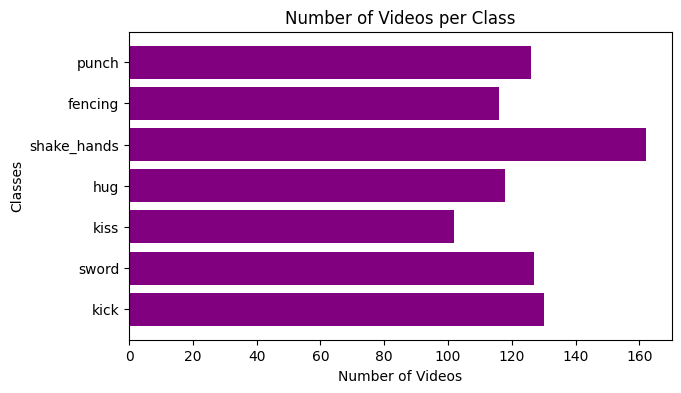

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.barh(df['Classes'], df['Videos'], color='purple')
plt.ylabel('Classes')
plt.xlabel('Number of Videos')
plt.title('Number of Videos per Class')
plt.show()

All classes seems to be quite equally balanced, so no video discarding is required.

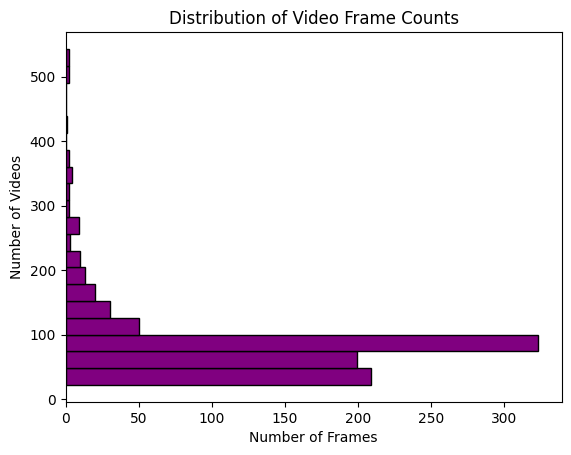

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def count_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

def get_video_paths(root_folder):
    video_paths = []
    for class_folder in os.listdir(root_folder):
        class_folder_path = os.path.join(root_folder, class_folder)
        if os.path.isdir(class_folder_path):
            for video_file in os.listdir(class_folder_path):
                video_path = os.path.join(class_folder_path, video_file)
                if os.path.isfile(video_path):
                    video_paths.append(video_path)
    return video_paths

def plot_frame_histogram(frame_counts):
    plt.hist(frame_counts, bins=20, edgecolor='black', color='purple', orientation='horizontal')
    plt.xlabel('Number of Frames')
    plt.ylabel('Number of Videos')
    plt.title('Distribution of Video Frame Counts')
    plt.show()

# Path to the root folder containing the class subfolders
root_folder = 'hmdb51_org_human_inter'

# Get all video paths
video_paths = get_video_paths(root_folder)

# Count frames for each video
frame_counts = [count_frames(video_path) for video_path in video_paths]

# Plot the histogram
plot_frame_histogram(frame_counts)


## **<font style="color:rgb(134,19,348)">4- TRAINING AND TEST CREATION</font>**

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We've created a function **`frames_extraction()`** that generates a list containing the resized and normalized frames of a video, given its path as an argument. The function reads the video file frame by frame, but not all frames are added to the list since we only need an evenly distributed sequence length of frames. If the video has fewer frames than required, the function duplicates the frames to reach the necessary number.

In [69]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    If the video has fewer frames than required, it will duplicate frames to meet the requirement.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not video_reader.isOpened():
        print(f"Error: Couldn't read video stream from file {video_path}")
        return frames_list

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # If the video has fewer frames than required, duplicate frames to meet the requirement.
    if video_frames_count < SEQUENCE_LENGTH:

        frame_indices = np.round(np.linspace(0, video_frames_count-1, SEQUENCE_LENGTH)).astype(int)

    else:
        # Calculate the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
        frame_indices = [frame_counter * skip_frames_window for frame_counter in range(SEQUENCE_LENGTH)]

    # Iterate through the selected frame indices.
    for idx in frame_indices:

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255.0

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Ensure the frames list has exactly SEQUENCE_LENGTH frames if it has any frames
    if frames_list:
        while len(frames_list) < SEQUENCE_LENGTH:
            frames_list.append(frames_list[-1])

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Frame extraction Preview</font>**

Below is a preview of how a video is segmented into a sequence of evenly spaced frames. In this case, we print a reduced number of frames for practical reasons and readability of the notebook; during network training, 60 evenly spaced frames will be extracted from each video.

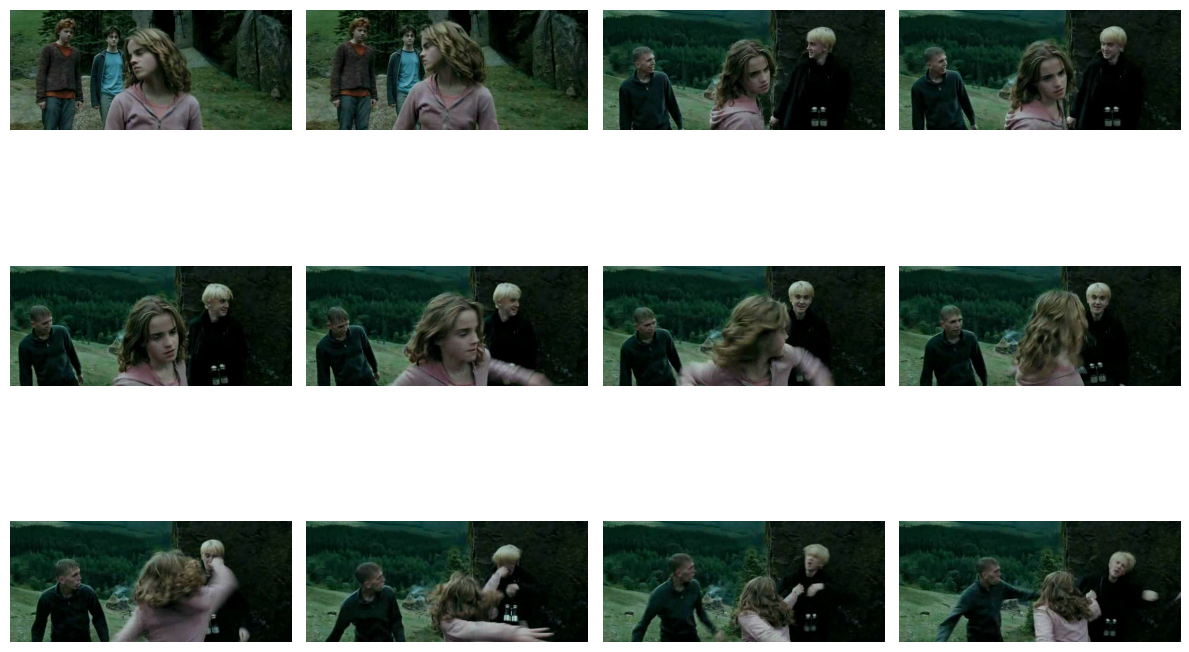

In [128]:
def frames_extraction_prev(video_path):
    # Carica il video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Determina gli indici dei 12 frame equidistanti
    frame_indices = np.linspace(0, total_frames , 13).astype(int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Converti il frame da BGR a RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Normalizza i valori dei pixel a [0, 1]
            frame = frame / 255.0
            frames.append(frame)

    cap.release()
    return np.array(frames)

def view_frame(frames_array):
    # Crea una figura con una griglia di 3x4
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()

    for i, frame in enumerate(frames_array):
        frame_rgb = (frame * 255).astype(np.uint8)  # Converte da [0, 1] a [0, 255] e casta a uint8
        axes[i].imshow(frame_rgb)
        axes[i].axis('off')  # Disabilita gli assi

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
video_path = 'hmdb51_org_human_inter/punch/HP_PRISONER_OF_AZKABAN_punch_u_cm_np1_ba_med_24.avi'
frames_array = frames_extraction_prev(video_path)
view_frame(frames_array)


Here is an example of how each frame is resized before being fed into the network.

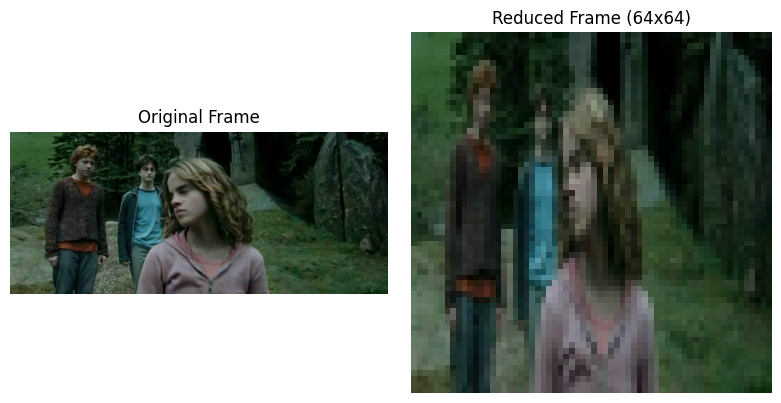

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def frames_extraction_prev(video_path):
    # Carica il video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Determina il primo frame
    frame_index = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()

    if ret:
        # Converti il frame da BGR a RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Normalizza i valori dei pixel a [0, 1]
        frame = frame / 255.0

    cap.release()
    return frame

def visualizza_frame_affiancati(frame):
    # Crea una versione ridotta del frame
    frame_ridotto = cv2.resize(frame, (64, 64), interpolation=cv2.INTER_AREA)

    # Converti i frame da [0, 1] a [0, 255] e casta a uint8 per visualizzazione
    frame_rgb = (frame * 255).astype(np.uint8)
    frame_ridotto_rgb = (frame_ridotto * 255).astype(np.uint8)

    # Crea una figura con 1 riga e 2 colonne
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(frame_rgb)
    axes[0].axis('off')
    axes[0].set_title('Original Frame')
    axes[1].imshow(frame_ridotto_rgb)
    axes[1].axis('off')
    axes[1].set_title('Reduced Frame (64x64)')

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
video_path = 'hmdb51_org_human_inter/punch/HP_PRISONER_OF_AZKABAN_punch_u_cm_np1_ba_med_24.avi'
first_frame = frames_extraction_prev(video_path)
visualizza_frame_affiancati(first_frame)

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

We created a function **`create_dataset()`** that iterates through all the classes specified in the **`CLASSES_LIST`** constant, calls the **`frames_extraction()`** function on every video file of the selected classes, and returns the frames (**`features`**), class index (**`labels`**), and video file paths (**`video_files_paths`**).

In [70]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Then, we've utilized the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [71]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: kick
Extracting Data of Class: sword
Extracting Data of Class: kiss
Extracting Data of Class: hug


OpenCV: Couldn't read video stream from file "hmdb51_org_unrared/hug/Free_Hugs_-_Paris_www_calins-gratuits_com_hug_f_cm_np2_ba_med_4.avi"


Error: Couldn't read video stream from file hmdb51_org_unrared/hug/Free_Hugs_-_Paris_www_calins-gratuits_com_hug_f_cm_np2_ba_med_4.avi
Extracting Data of Class: shake_hands
Extracting Data of Class: fencing


OpenCV: Couldn't read video stream from file "hmdb51_org_unrared/fencing/1899_Hamlet__the_Fencing_Scene_with_Laertes_fencing_f_cm_np2_le_med_0.avi"


Error: Couldn't read video stream from file hmdb51_org_unrared/fencing/1899_Hamlet__the_Fencing_Scene_with_Laertes_fencing_f_cm_np2_le_med_0.avi
Extracting Data of Class: punch


Finally, `labels` (class indexes) are converted into one-hot encoded vectors.

In [75]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

We had obtained the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a NumPy array containing all class labels in one hot encoded format). Next, we had split our data to create training and testing sets. We had also shuffled the dataset before the split to avoid any bias and to ensure the splits represented the overall distribution of the data.

In [76]:
from sklearn.model_selection import train_test_split

# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">5 - 3D CNN Approach</font>**

The code imports TensorFlow and defines a **`3D Convolutional Neural Network`** (CNN) used for processing spatiotemporal data such as videos or three-dimensional data volumes. The network is designed to automatically learn hierarchical features from such data, utilizing 3D convolutional layers that scan the data volume in three dimensions rather than two, as in traditional CNNs. This type of network is effective for tasks like video classification, where considering both spatial layout and temporal sequence of information is crucial. ([Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification))

In [93]:
# Configurations
num_classes = one_hot_encoded_labels.shape[1]  # Number of Catgeories
input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3) # Frame per Video

In [94]:
num_classes, input_shape

(7, (60, 64, 64, 3))

The built network architecture includes:

- **Input Layer:** Accepts 3D video data (`input_shape`).
- **Convolutional Layers:**
  - **First Layer:** 32 filters, (3, 3, 3) kernel, ReLU activation, max pooling, and dropout.
  - **Second Layer:** 64 filters, (3, 3, 3) kernel, ReLU activation, max pooling, and dropout.
- **Flatten Layer:** Converts 3D output to 1D vector.
- **Dense Layer:** 64 units, ReLU activation, and dropout.
- **Output Layer:** `num_classes` units, softmax activation.

L2 regularization (`kernel_regularizer=l2(0.01)`) and `Dropout` layers are applied to prevent overfitting.

The model's summary provides details on the architecture and parameters.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2


def build_3d_cnn(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))

    # Second Convolutional Layer
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))

    # Flatten
    model.add(Flatten())

    # Dense Layer
    model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

    model.summary()
    return model

In [ ]:
# Construct the required convlstm model.
conv3Dmodel = build_3d_cnn(input_shape, num_classes)

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 58, 62, 62, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 29, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 27, 29, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 13, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 163072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    10,436,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,495,111 (40.04 MB)

 Trainable params: 10,495,111 (40.04 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
# Create an Instance of Early Stopping Callback
from tensorflow import keras
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
conv3Dmodel.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

# Start training the model.
conv3Dmodel_training_history = conv3Dmodel.fit(x = features_train, y = labels_train, epochs = 60, batch_size = 8,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.1581 - loss: 9.2191 - val_accuracy: 0.1667 - val_loss: 2.6090
Epoch 2/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.2158 - loss: 2.4192 - val_accuracy: 0.2652 - val_loss: 2.2003
Epoch 3/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.2342 - loss: 2.1573 - val_accuracy: 0.2879 - val_loss: 2.1005
Epoch 4/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.2818 - loss: 2.0845 - val_accuracy: 0.2652 - val_loss: 2.0514
Epoch 5/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.3179 - loss: 2.0252 - val_accuracy: 0.3485 - val_loss: 2.0062
Epoch 6/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.3466 - loss: 1.9552 - val_accuracy: 0.3485 - val_loss: 1.9656
Epoch 7/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.3627 - loss: 1.8966 - val_accuracy: 0.3712 - val_loss: 1.8956
Epoch 8/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.3840 - loss: 1.8974 - val_accuracy: 0.4167 - v

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we evaluated the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = conv3Dmodel.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4315 - loss: 1.9144


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we've saved the model for future uses.

In [118]:
os.makedirs('conv3D_v1')
conv3Dmodel.save('conv3D_v1/conv3Dmodel_v1.keras')
conv3Dmodel.save_weights('conv3D_v1/conv3Dmodel_v1_weights.weights.h5')

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**

The function **`plot_metric()`** allows to visualize how the training and validation metrics of this model have evolved over the epochs.

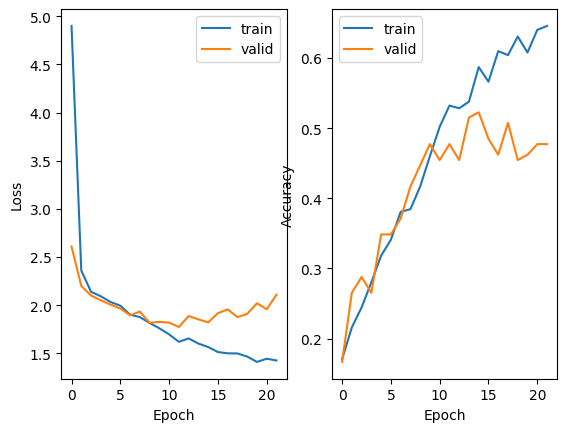

In [ ]:
# Visualization of the learning curves
plt.subplot(1, 2, 1)
plt.plot(conv3Dmodel_training_history.history['loss'])
plt.plot(conv3Dmodel_training_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(conv3Dmodel_training_history.history['accuracy'])
plt.plot(conv3Dmodel_training_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

## **<font style="color:rgb(134,19,348)">Contingency table</font>**

Finally, we attempt to load the trained model and compare classification predictions with actual labels, visualizing them in a contingency matrix.

In [123]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conv3Dmodel = load_model('conv3D_v1/conv3Dmodel_v1.keras')

# Make predictions on new data
predictions_3d = conv3Dmodel.predict(features_test) # `predictions` contains the predicted probabilities for each output class

predicted_classes_3d = np.argmax(predictions_3d, axis=-1)

numeric_labels_3d = np.argmax(labels_test, axis=1)

pred_class_3d= predicted_classes_3d.tolist()

# Build the contingency table (confusion matrix)
conf_matrix_3d = confusion_matrix(numeric_labels_3d, pred_class_3d)

import pandas as pd
conf_matrix_df_3d = pd.DataFrame(conf_matrix_3d, 
                              index=[f'True_{CLASSES_LIST[i]}' for i in range(num_classes)], 
                              columns=[f'Pred_{CLASSES_LIST[i]}' for i in range(num_classes)])


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


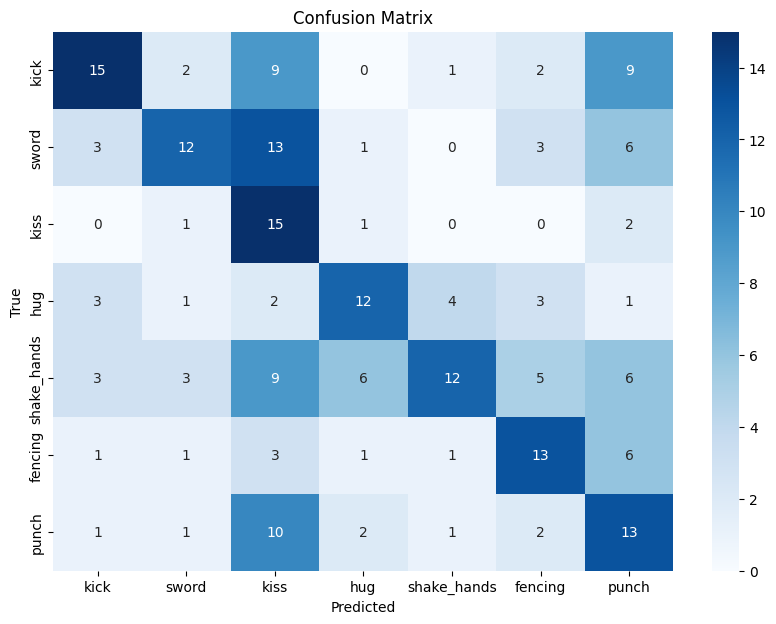

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3d, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

It's possible to notice how the model, consistent with its performance during training, does not correctly classify all videos, making more errors on the **kiss** and **punch** classes.

## **<font style="color:rgb(134,19,348)">6 - LRCN Approach</font>**

In this step, we implemented a Long-term Recurrent Convolutional Network (LRCN) ([Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------)), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

We've also used [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def LRCN_MODEL():
    '''
    This function will construct an optimized LRCN model for the HMDB51 dataset.
    Returns:
        model: The constructed LRCN model.
    '''

    # Define constants for the model
    SEQUENCE_LENGTH = 60  # Reduce sequence length to handle memory constraints
    IMAGE_HEIGHT = 64     # Define your image height
    IMAGE_WIDTH = 64      # Define your image width
    NUM_CLASSES = 7       # Number of classes in HMDB51 dataset

    # Initialize a Sequential model
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    # CNN layers with TimeDistributed wrapper
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))

    # Flatten layer to feed into LSTM
    model.add(TimeDistributed(Flatten()))

    # LSTM layer
    model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

    # Dense layer for classification
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    ########################################################################################################################

    # Display the model's summary
    model.summary()

    # Return the constructed LRCN model
    return model

Then, we utilized the function **`LRCN_model()`** created above to construct the required `LRCN` model.

In [87]:
# Construct the required LRCN model.
LRCN_model = LRCN_MODEL()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_112            │ (None, 60, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_113            │ (None, 60, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_114            │ (None, 60, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_115            │ (None, 60, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_116            │ (None, 60, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_117            │ (None, 60, 32, 32, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_118            │ (None, 60, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_119            │ (None, 60, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_120            │ (None, 60, 16, 16, 32) │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_121            │ (None, 60, 16, 16, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_122            │ (None, 60, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_123            │ (None, 60, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_124            │ (None, 60, 8, 8, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_125            │ (None, 60, 8, 8, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_126            │ (None, 60, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_127            │ (None, 60, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_128            │ (None, 60, 1024)       │             

 Total params: 312,647 (1.19 MB)

 Trainable params: 312,359 (1.19 MB)

 Non-trainable params: 288 (1.12 KB)

Model Created Successfully!


### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**


After checking the structure, we've compiled and started training the model.

In [88]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [89]:
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 80, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 659s 9s/step - accuracy: 0.1911 - loss: 2.9636 - val_accuracy: 0.2879 - val_loss: 2.8064
Epoch 2/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 605s 9s/step - accuracy: 0.3101 - loss: 2.7057 - val_accuracy: 0.3182 - val_loss: 2.6827
Epoch 3/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 591s 9s/step - accuracy: 0.3931 - loss: 2.5269 - val_accuracy: 0.3333 - val_loss: 2.5468
Epoch 4/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 638s 10s/step - accuracy: 0.4324 - loss: 2.4023 - val_accuracy: 0.3561 - val_loss: 2.5581
Epoch 5/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 612s 9s/step - accuracy: 0.4342 - loss: 2.3158 - val_accuracy: 0.3258 - val_loss: 2.3703
Epoch 6/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 591s 9s/step - accuracy: 0.4151 - loss: 2.2916 - val_accuracy: 0.4091 - val_loss: 2.3771
Epoch 7/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 585s 9s/step - accuracy: 0.4946 - loss: 2.1701 - val_accuracy: 0.4242 - val_loss: 2.2574
Epoch 8/80
66/66 ━━━━━━━━━━━━━━━━━━━━ 591s 9s/step - accuracy: 0.5271 - loss: 2.0846 - val_accuracy: 0.4621 - 

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we've evaluated the `LRCN` model on the test set.

In [90]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 797ms/step - accuracy: 0.5695 - loss: 1.7269


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we've saved the model for future uses, with the same technique used previously.

In [98]:
os.makedirs('LRCN_model')
LRCN_model.save('LRCN_model/LRCN_model.keras')
LRCN_model.save_weights('LRCN_model/LRCN_model_weights.weights.h5')

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**

The function **`plot_metric()`** allows to visualize how the training and validation metrics of this model have evolved over the epochs.

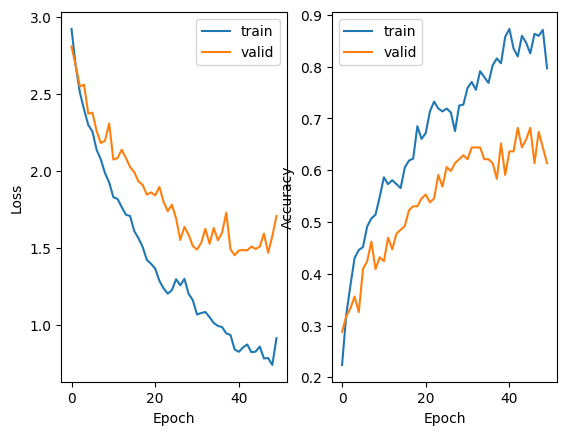

In [101]:
plt.subplot(1, 2, 1)
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
#plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
#plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

## **<font style="color:rgb(134,19,348)">Contingency table</font>**

Finally, we attempt to load the trained model and compare classification predictions with actual labels, visualizing them in a contingency matrix.

In [116]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lrcn_mod = load_model('LRCN_model/LRCN_model.keras')

# Make predictions on new data
predictions = lrcn_mod.predict(features_test) # `predictions` contains the predicted probabilities for each output class

predicted_classes = np.argmax(predictions, axis=-1)

numeric_labels = np.argmax(labels_test, axis=1)

pred_class = predicted_classes.tolist()

# Build the contingency table (confusion matrix)
conf_matrix = confusion_matrix(numeric_labels, pred_class)

import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=[f'True_{CLASSES_LIST[i]}' for i in range(num_classes)], 
                              columns=[f'Pred_{CLASSES_LIST[i]}' for i in range(num_classes)])


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 


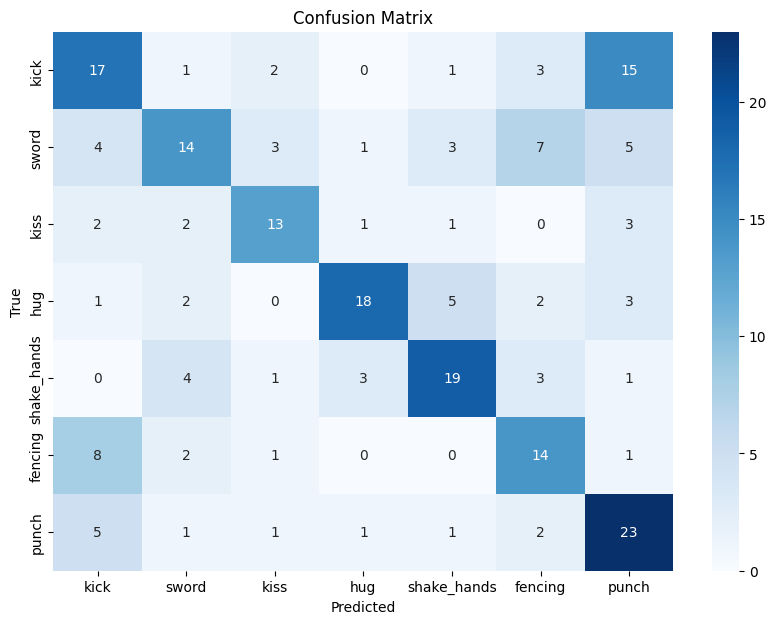

In [117]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Compared to the previous model, the number of misclassifications is lower, although the performance on the **punch** class remains worse.

## **<font style="color:rgb(134,19,348)">7 - References and Useful Links</font>**

Here it's possible to find the **trained models**: https://drive.google.com/drive/folders/1F00GY0uog9f6-xQFowanqnlCZ1dg47Xr?usp=share_link 


**References**

https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/

https://paperswithcode.com/task/video-classification 

https://arxiv.org/abs/1505.06250 

https://towardsdatascience.com/introduction-to-video-classification-6c6acbc57356 

https://www.neuralconcept.com/post/3d-convolutional-neural-network-a-guide-for-engineers 

https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610 

https://eitca.org/artificial-intelligence/eitc-ai-dltf-deep-learning-with-tensorflow/3d-convolutional-neural-network-with-kaggle-lung-cancer-detection-competiton/running-the-network-3d-convolutional-neural-network-with-kaggle-lung-cancer-detection-competiton/examination-review-running-the-network-3d-convolutional-neural-network-with-kaggle-lung-cancer-detection-competiton/how-does-a-3d-convolutional-neural-network-differ-from-a-2d-network-in-terms-of-dimensions-and-strides/ 

https://www.tensorflow.org/tutorials/video/video_classification 

https://keras.io/api/applications/ 

https://arxiv.org/abs/1411.4389?source=post_page 

https://keras.io/api/layers/recurrent_layers/time_distributed/ 

https://paperswithcode.com/sota/action-recognition-in-videos-on-hmdb-51